In [ ]:
!pip install pandas
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Path file Excel
file_path = '/content/heart_attack_reduksi (1).csv'

# Membaca file Excel

df = pd.read_csv(file_path)
# Menampilkan 5 baris pertama
df.head()

,age,gender,hypertension,diabetes,cholesterol_level,smoking_status,obesity,family_history,stress_level,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,fasting_blood_sugar,triglycerides,EKG_results,previous_heart_disease,medication_usage,heart_attack
0,60,Male,0,1,211,Never,0,0,Moderate,5.970603,113,62,173,101,Normal,0,0,0
1,53,Female,0,0,208,Past,0,1,High,5.643813,132,76,70,138,Normal,1,0,0
2,62,Female,0,0,231,Past,1,1,Low,6.336197,116,74,118,171,Abnormal,0,1,1
3,73,Male,1,0,202,Never,0,1,High,7.912990,136,65,98,146,Normal,0,1,0
4,52,Male,1,0,232,Current,0,0,Moderate,3.252338,127,75,104,139,Normal,1,0,1


<ipython-input-3-aea19c06338b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='heart_attack', palette='pastel')


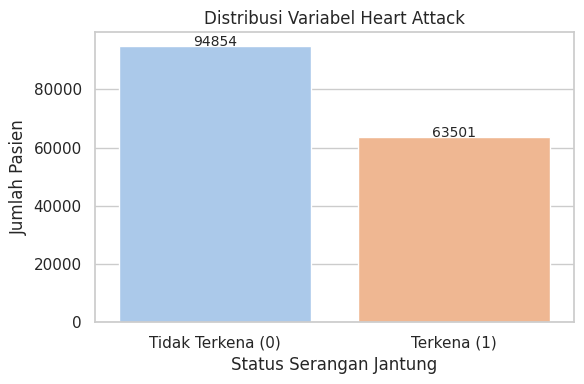

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur tema visualisasi
sns.set(style="whitegrid")

# Membuat figure
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='heart_attack', palette='pastel')

# Memberi label dan judul
plt.xticks([0, 1], ['Tidak Terkena (0)', 'Terkena (1)'])
plt.xlabel('Status Serangan Jantung')
plt.ylabel('Jumlah Pasien')
plt.title('Distribusi Variabel Heart Attack')

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5,
            f'{int(height)}', ha="center", fontsize=10)

# Menampilkan plot
plt.tight_layout()
plt.show()

## RBF BOOSTRAP 10x

Bootstrap iteration: 1
Bootstrap iteration: 2
Bootstrap iteration: 3
Bootstrap iteration: 4
Bootstrap iteration: 5
Bootstrap iteration: 6
Bootstrap iteration: 7
Bootstrap iteration: 8
Bootstrap iteration: 9
Bootstrap iteration: 10
=== Rata-Rata Hasil Evaluasi Bootstrap RBF 1000 10x ===
bootstrap                   5.500000
C                          10.525000
gamma                       0.009697
train_accuracy              0.789750
test_accuracy               0.704000
train_balanced_accuracy     0.766247
test_balanced_accuracy      0.674298
train_precision             0.782102
test_precision              0.658984
train_recall                0.652483
test_recall                 0.531112
train_f1_score              0.711122
test_f1_score               0.586846
dtype: float64


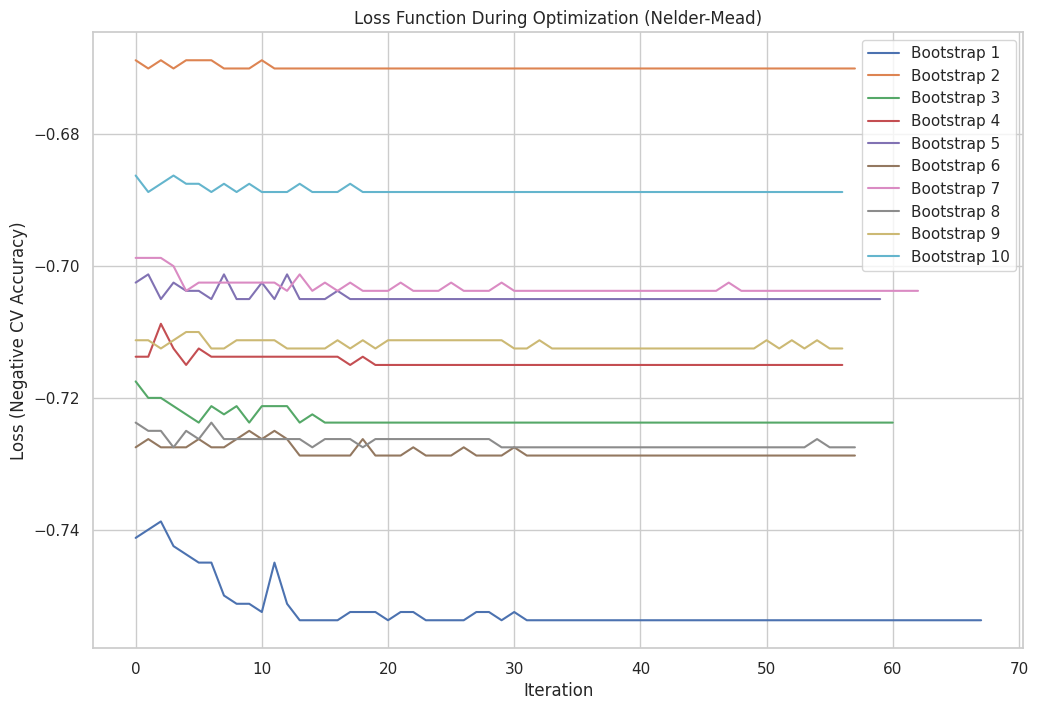

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(10):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='rbf')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Evaluasi Bootstrap RBF 1000 10x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## LINEAR BOOSTRAP 10

Bootstrap iteration: 1
Bootstrap iteration: 2
Bootstrap iteration: 3
Bootstrap iteration: 4
Bootstrap iteration: 5
Bootstrap iteration: 6
Bootstrap iteration: 7
Bootstrap iteration: 8
Bootstrap iteration: 9
Bootstrap iteration: 10
=== Rata-Rata Hasil Bootstrap LINEAR 1000 10x ===
bootstrap                   5.500000
C                          10.021875
gamma                       0.010016
train_accuracy              0.742250
test_accuracy               0.710000
train_balanced_accuracy     0.714836
test_balanced_accuracy      0.681558
train_precision             0.715265
test_precision              0.666231
train_recall                0.582256
test_recall                 0.542858
train_f1_score              0.641638
test_f1_score               0.597766
dtype: float64


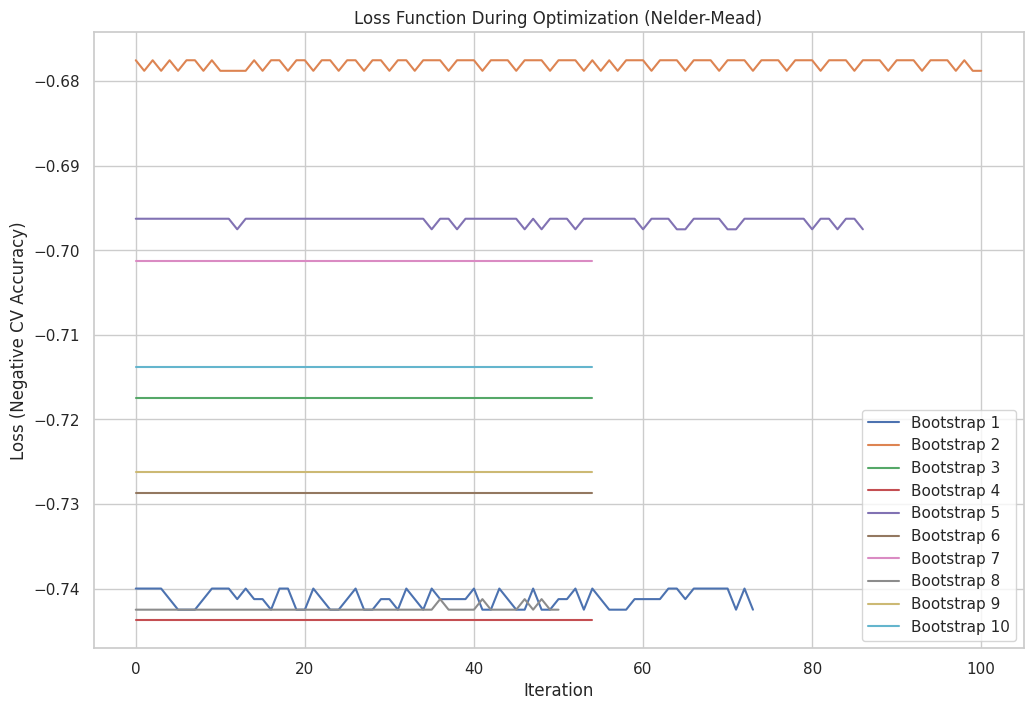

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='linear')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(10):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='linear')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap LINEAR 1000 10x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## SIGMOID BOOSTRAP 10

Bootstrap iteration: 1
Bootstrap iteration: 2
Bootstrap iteration: 3
Bootstrap iteration: 4
Bootstrap iteration: 5
Bootstrap iteration: 6
Bootstrap iteration: 7
Bootstrap iteration: 8
Bootstrap iteration: 9
Bootstrap iteration: 10
=== Rata-Rata Hasil Bootstrap SIGMOID 1000 10x ===
bootstrap                  5.500000
C                          9.943555
gamma                      0.010463
train_accuracy             0.732375
test_accuracy              0.712500
train_balanced_accuracy    0.704213
test_balanced_accuracy     0.682674
train_precision            0.700819
test_precision             0.673555
train_recall               0.567802
test_recall                0.536836
train_f1_score             0.627140
test_f1_score              0.596822
dtype: float64


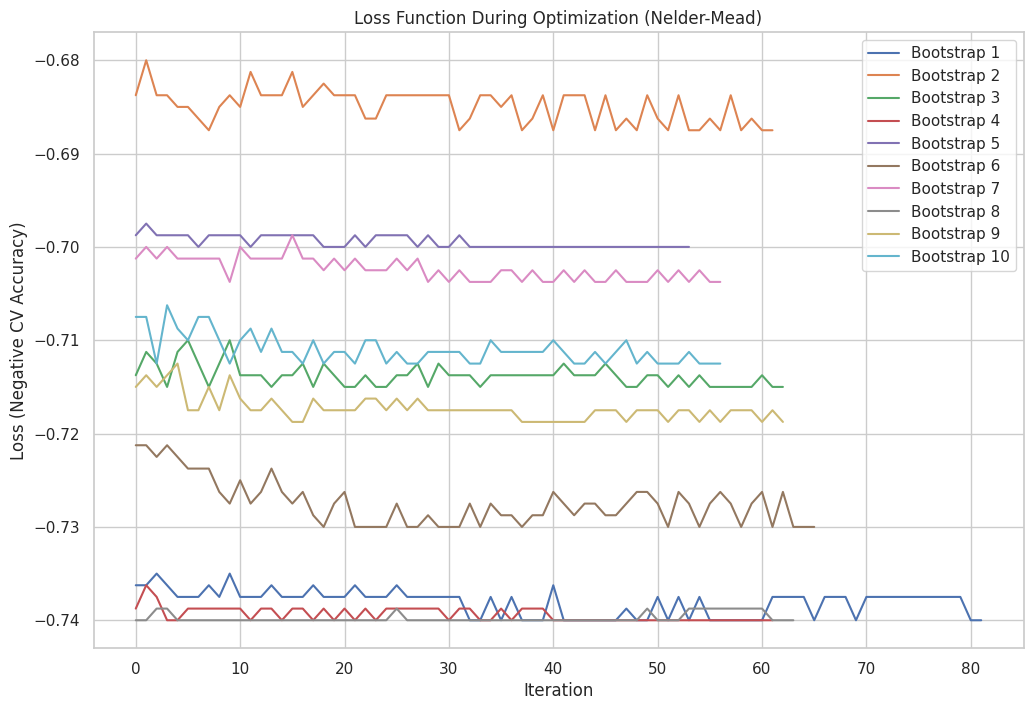

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='sigmoid')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(10):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='sigmoid')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap SIGMOID 1000 10x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## POLYNOM BOOSTRAP 10

Bootstrap iteration: 1


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 2


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 6


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 7


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 8


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 9


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Rata-Rata Hasil Bootstrap POLYNOM 1000 10x ===
bootstrap                   5.500000
C                          10.050000
gamma                       0.010050
train_accuracy              0.604750
test_accuracy               0.603000
train_balanced_accuracy     0.502988
test_balanced_accuracy      0.500000
train_precision             0.800000
test_precision              0.000000
train_recall                0.005976
test_recall                 0.000000
train_f1_score              0.011801
test_f1_score               0.000000
dtype: float64


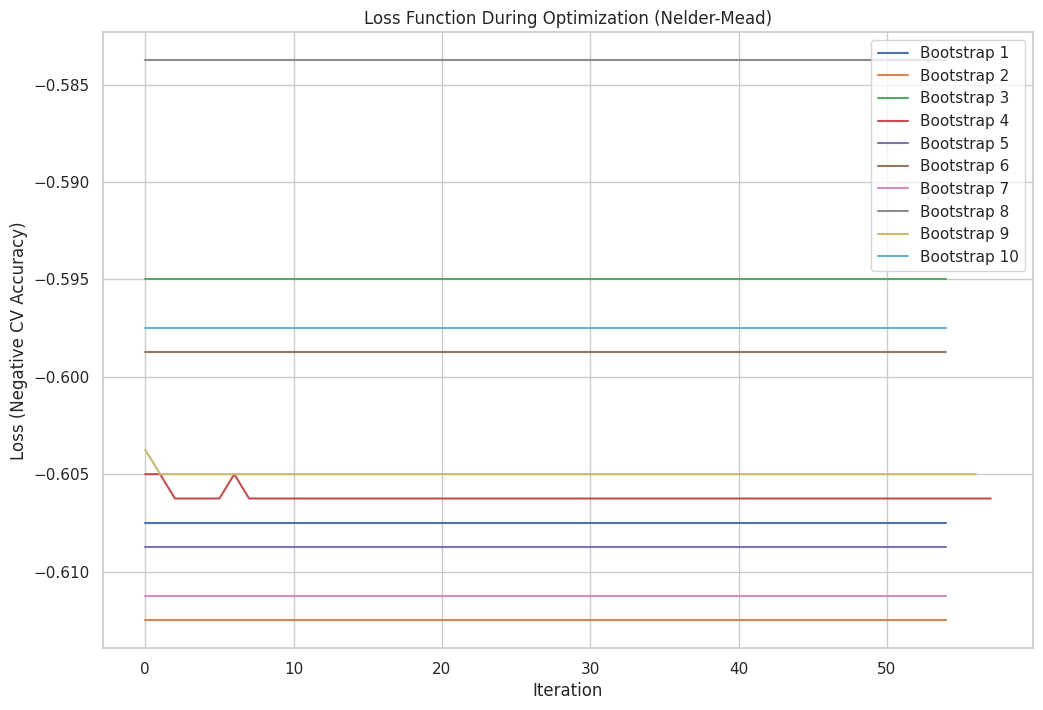

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='poly')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(10):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='poly')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap POLYNOM 1000 10x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## RBF BOOSTRAP 20

Bootstrap iteration: 1
Bootstrap iteration: 2
Bootstrap iteration: 3
Bootstrap iteration: 4
Bootstrap iteration: 5
Bootstrap iteration: 6
Bootstrap iteration: 7
Bootstrap iteration: 8
Bootstrap iteration: 9
Bootstrap iteration: 10
Bootstrap iteration: 11
Bootstrap iteration: 12
Bootstrap iteration: 13
Bootstrap iteration: 14
Bootstrap iteration: 15
Bootstrap iteration: 16
Bootstrap iteration: 17
Bootstrap iteration: 18
Bootstrap iteration: 19
Bootstrap iteration: 20
=== Rata-Rata Hasil Bootstrap RBF 1000 20x ===
bootstrap                  10.500000
C                          10.566016
gamma                       0.009409
train_accuracy              0.786687
test_accuracy               0.714000
train_balanced_accuracy     0.762442
test_balanced_accuracy      0.686744
train_precision             0.781174
test_precision              0.672721
train_recall                0.644741
test_recall                 0.553773
train_f1_score              0.705652
test_f1_score               0.605262
d

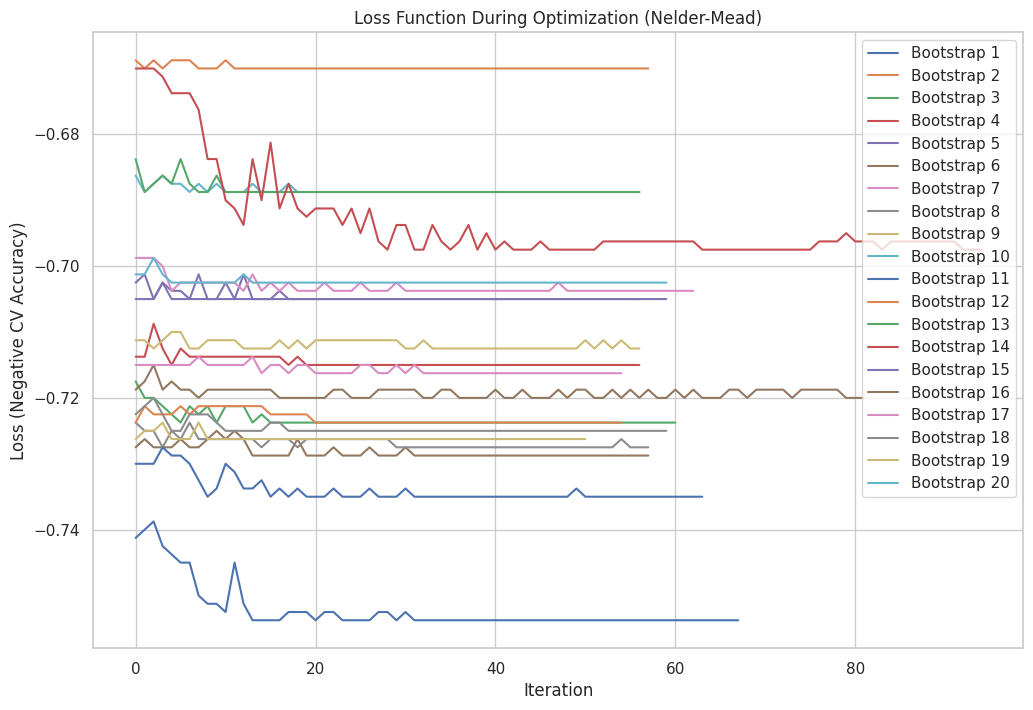

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(20):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='rbf')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap RBF 1000 20x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## LINEAR BOOSTRAP 20

Bootstrap iteration: 1
Bootstrap iteration: 2
Bootstrap iteration: 3
Bootstrap iteration: 4
Bootstrap iteration: 5
Bootstrap iteration: 6
Bootstrap iteration: 7
Bootstrap iteration: 8
Bootstrap iteration: 9
Bootstrap iteration: 10
Bootstrap iteration: 11
Bootstrap iteration: 12
Bootstrap iteration: 13
Bootstrap iteration: 14
Bootstrap iteration: 15
Bootstrap iteration: 16
Bootstrap iteration: 17
Bootstrap iteration: 18
Bootstrap iteration: 19
Bootstrap iteration: 20
=== Rata-Rata Hasil Bootstrap LINEAR 1000 20x ===
bootstrap                  10.500000
C                          10.053125
gamma                       0.010040
train_accuracy              0.740937
test_accuracy               0.721250
train_balanced_accuracy     0.714130
test_balanced_accuracy      0.694307
train_precision             0.713212
test_precision              0.683248
train_recall                0.584021
test_recall                 0.561601
train_f1_score              0.641547
test_f1_score               0.61514

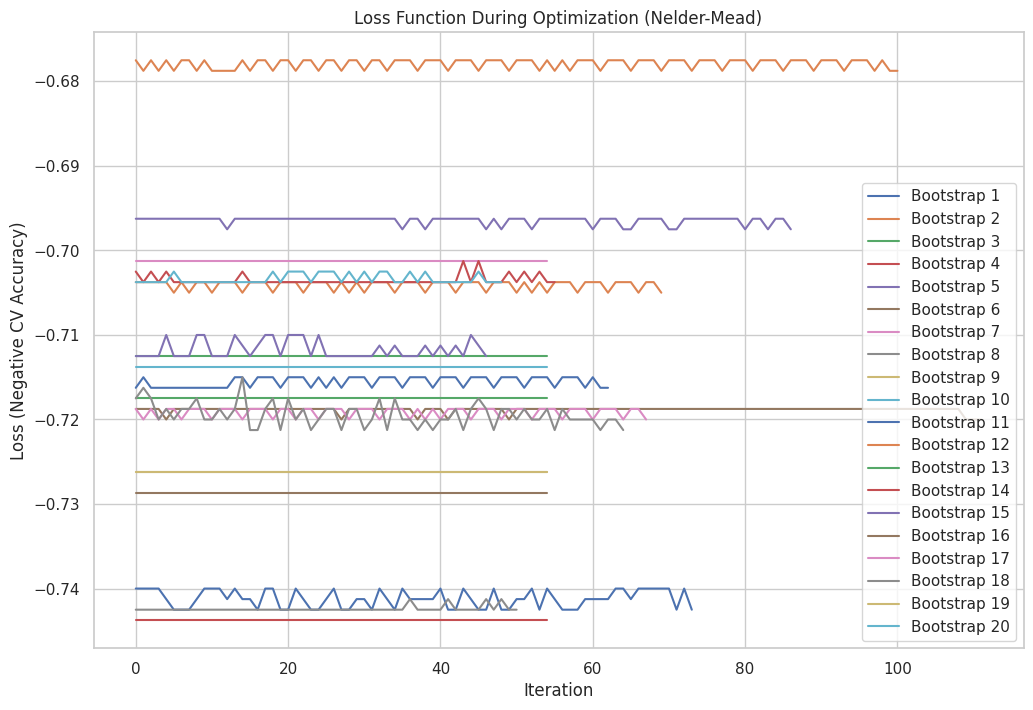

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='linear')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(20):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='linear')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap LINEAR 1000 20x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## SIGMOID BOOSTRAP 20

Bootstrap iteration: 1
Bootstrap iteration: 2
Bootstrap iteration: 3
Bootstrap iteration: 4
Bootstrap iteration: 5
Bootstrap iteration: 6
Bootstrap iteration: 7
Bootstrap iteration: 8
Bootstrap iteration: 9
Bootstrap iteration: 10
Bootstrap iteration: 11
Bootstrap iteration: 12
Bootstrap iteration: 13
Bootstrap iteration: 14
Bootstrap iteration: 15
Bootstrap iteration: 16
Bootstrap iteration: 17
Bootstrap iteration: 18
Bootstrap iteration: 19
Bootstrap iteration: 20
=== Rata-Rata Hasil Bootstrap SIGMOID 1000 20x ===
bootstrap                  10.500000
C                          10.150293
gamma                       0.010236
train_accuracy              0.732375
test_accuracy               0.721000
train_balanced_accuracy     0.704139
test_balanced_accuracy      0.692879
train_precision             0.702834
test_precision              0.685950
train_recall                0.567030
test_recall                 0.554205
train_f1_score              0.627010
test_f1_score               0.6115

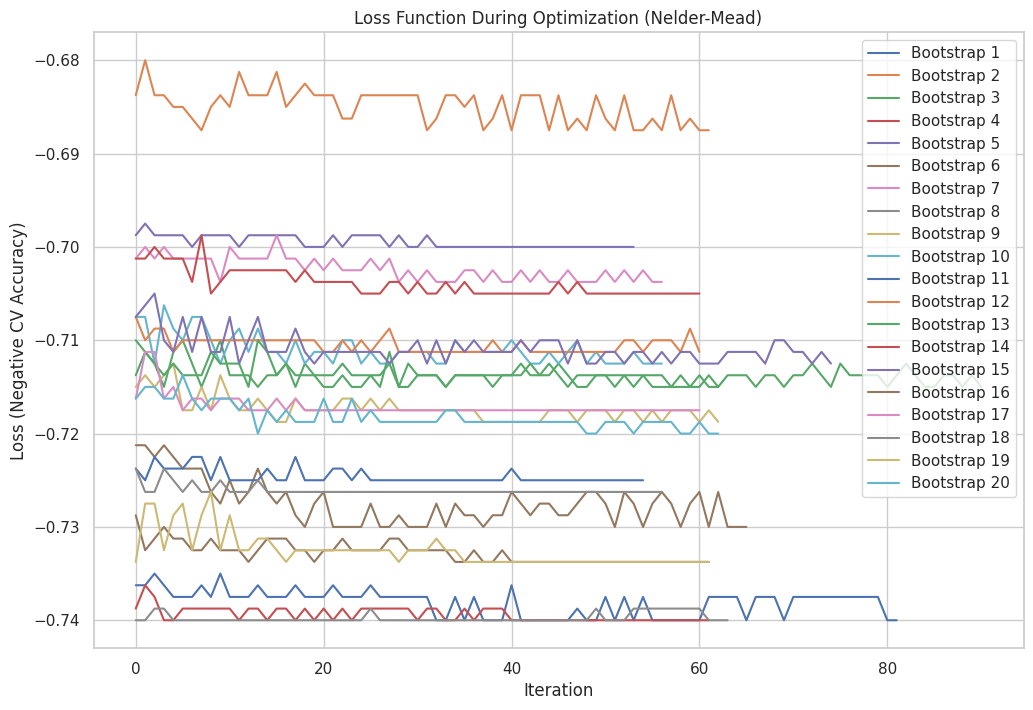

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='sigmoid')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(20):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='sigmoid')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap SIGMOID 1000 20x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()


## POLYNOM BOOSTRAP 20

Bootstrap iteration: 1


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 2


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 6


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 7


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 8


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 9


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 11


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 13


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 14


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 15


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 16


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 17


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 18


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 19


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bootstrap iteration: 20


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Rata-Rata Hasil Bootstrap POLYNOM 1000 20x ===
bootstrap                  10.500000
C                          10.025000
gamma                       0.010025
train_accuracy              0.603875
test_accuracy               0.601500
train_balanced_accuracy     0.502821
test_balanced_accuracy      0.500312
train_precision             0.750000
test_precision              0.050000
train_recall                0.005641
test_recall                 0.000625
train_f1_score              0.011160
test_f1_score               0.001235
dtype: float64


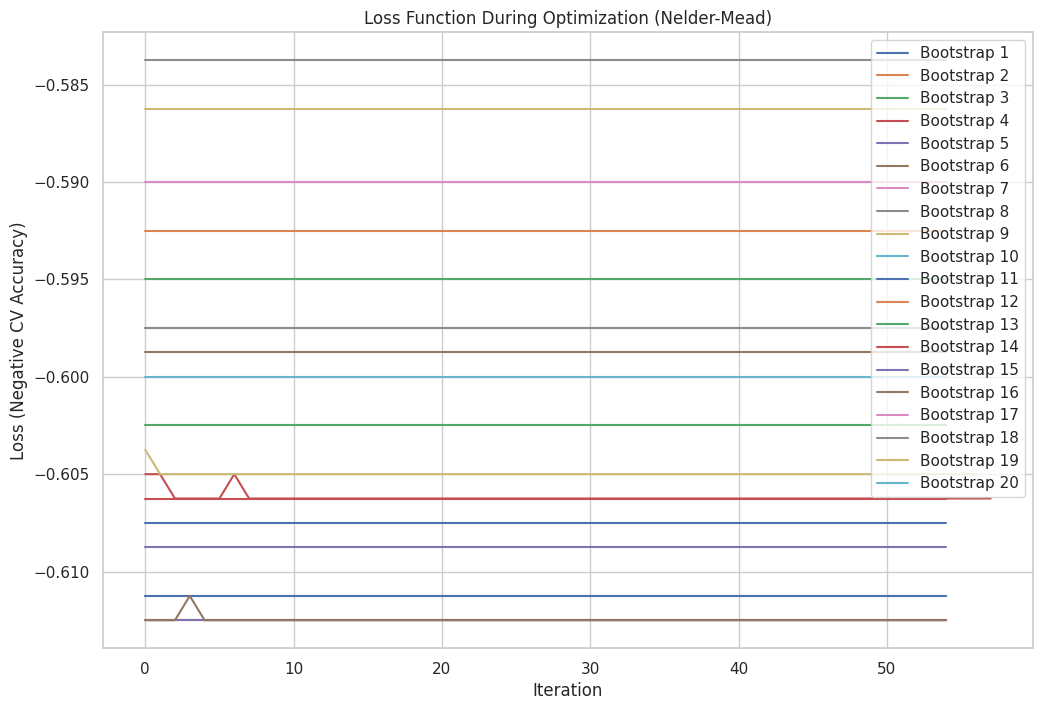

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Simpan nilai loss global untuk visualisasi
loss_history = []

# Target dan fitur
y = df['heart_attack']
X = df.drop(columns='heart_attack')

# Deteksi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Objective function dengan C lebih besar dan gamma kecil
def objective(params):
    C, gamma = params
    if C <= 0 or gamma <= 0:
        return 1.0
    model = SVC(C=C, gamma=gamma, kernel='poly')
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    loss = -scores.mean()
    loss_history.append(loss)  # Simpan loss untuk tiap evaluasi
    return loss

# Optimasi dengan initial_guess baru
from scipy.optimize import minimize
def optimize_svm():
    global loss_history
    loss_history = []  # reset tiap optimasi
    initial_guess = [10, 0.01]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

# Bootstrap dan evaluasi
results = []
for i in range(20):
    print(f"Bootstrap iteration: {i+1}")
    df_bootstrap = df.sample(n=1000, replace=True, random_state=i)
    y = df_bootstrap['heart_attack']
    X = df_bootstrap.drop(columns='heart_attack')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    C_opt, gamma_opt = optimize_svm()
    model = SVC(C=C_opt, gamma=gamma_opt, kernel='poly')
    model.fit(X_train_proc, y_train)

    y_train_pred = model.predict(X_train_proc)
    y_test_pred = model.predict(X_test_proc)

    results.append({
        'bootstrap': i + 1,
        'C': C_opt,
        'gamma': gamma_opt,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1_score': f1_score(y_train, y_train_pred),
        'test_f1_score': f1_score(y_test, y_test_pred),
        'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
        'test_conf_matrix': confusion_matrix(y_test, y_test_pred),
        'loss_history': loss_history.copy()  # simpan loss tiap bootstrap
    })

# Konversi hasil ke DataFrame dan hitung rata-rata
df_results = pd.DataFrame(results)
mean_results = df_results.drop(columns=['train_conf_matrix', 'test_conf_matrix', 'loss_history']).mean(numeric_only=True)

print("=== Rata-Rata Hasil Bootstrap POLYNOM 1000 20x ===")
print(mean_results)

# Visualisasi loss function untuk setiap bootstrap
plt.figure(figsize=(12, 8))
for i, loss_hist in enumerate(df_results['loss_history']):
    plt.plot(loss_hist, label=f'Bootstrap {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss (Negative CV Accuracy)')
plt.title('Loss Function During Optimization (Nelder-Mead)')
plt.legend()
plt.show()
